**Created on 15/12/2022**

**Authors: Amir Najjar, Sibel Yuksel**

**License: this notebook is released under the CeCILL 2.1 license. See https://www.cecill.info/licenses/Licence_CeCILL_V2.1-en.txt**

# Dataset 1 and Dataset 2 creation

Parts of this code are adapted from `draw.py` created by Quentin Vey.

## Installations and Imports

It is recommended to install `ndjson` to work with the Newline Delimited JSON files provided by LocURa4IoT. More about `ndjson` [here](http://ndjson.org/) and [here](https://pypi.org/project/ndjson/).

In [ ]:
!pip install ndjson

We import the required libraries and set the seaborn theme to `darkgrid` as specified in the quality cheat sheet. We also specify the directory where the data is located:

In [ ]:
import ndjson
import json
import os
import base64
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

In [ ]:
def create_folder(directory: str) -> None:
    """
    Create a folder using a directory

    Parameters: 
        directory: directory of the folder to create
    """
    if not os.path.isdir(directory):
        os.makedirs(directory)

create_folder("./Datasets")
create_folder("./Datasets/Dataset_1")
create_folder("./Datasets/Dataset_2")

In [ ]:
DATA_LOC_LCN = './Data/20220611-uwb-twr.json'
EXPORT_LOC = './Datasets'

## Data loading

We then load the data from the file into a DataFrame and preview it:

In [ ]:
with open(DATA_LOC_LCN) as f :
    try:
        data = ndjson.load(f)
    except Exception as e:
        raise e

In [ ]:
dataset_complete = pd.DataFrame(data)
dataset_complete.head()

,initiator,target,protocol,t1,t2,t3,t4,skew,nlosIndicator,tof,...,rssiRequest,rssiData,rssiAck,temperature,distantTemperature,registerDump_CIR,timestamp,localisation,distance,rangingError
0,183,184,TWR,920039862414,919985093202,920088686222,920143454647,-6.768011,3.155145,-393,...,-78.764832,-79.384056,-78.736259,30.98,36.299999,{'ACC_MEM': '//3/uQAI/7MABv/BAAX/zAAA/8X/+/+o/...,1654929793818,"{'initiator': {'x': 2.12, 'y': 2.793, 'z': 2.6...",0.000,-0.201
1,183,180,TWR,932451320462,932829726139,932932770958,932554367776,-1.753530,148.517426,1247,...,-79.625259,-79.530046,-79.945788,30.98,30.980001,{'ACC_MEM': 'ADL/+QAtAA0AIf/1ABz/3f/8/////AAH/...,1654929794012,"{'initiator': {'x': 2.12, 'y': 2.793, 'z': 2.6...",6.329,-0.054
2,183,100,TWR,946218857614,946490292658,946594234510,946322802711,-2.368804,2.783982,1622,...,-80.136574,-79.836296,-80.07713,30.98,30.220001,{'ACC_MEM': 'AAT/9gACAAr/+wABAAL/8wAS//AACgAGA...,1654929794228,"{'initiator': {'x': 2.12, 'y': 2.793, 'z': 2.6...",7.962,0.226
3,183,101,TWR,958585021070,958973595867,959077448334,958688875846,-1.107493,20.052750,1154,...,-79.081566,-78.998866,-79.23105,30.41,27.559999,{'ACC_MEM': 'AA0ACAABAAkAJf/tAEX/zgA4/9YABf///...,1654929794421,"{'initiator': {'x': 2.12, 'y': 2.793, 'z': 2.6...",5.475,0.210
4,183,171,TWR,970962930318,971212491155,971316977806,971067418859,2.707205,2.452256,945,...,-78.702545,-79.435472,-79.50462,30.98,29.460001,{'ACC_MEM': 'ABsAD//7AAcABAAjAAMAE//2AAX/+wAN/...,1654929794614,"{'initiator': {'x': 2.12, 'y': 2.793, 'z': 2.6...",3.761,0.008


In [ ]:
print(f'Number of columns in DataFrame: {len(dataset_complete.columns)}')

Number of columns in DataFrame: 26


## Data preprocessing

We sort the DataFrame on `target` and `timestamp`:

In [ ]:
dataset_complete.sort_values(by=['target', 'timestamp'], inplace=True)
dataset_complete.reset_index(inplace=True)

We transform the dictionary column `localisation` into 6 columns `loc_initiator_x/y/z` and `loc_target_x/y/z`:

In [ ]:
dataset_complete['loc_initiator_x'] = dataset_complete.localisation.apply(lambda loc: loc['initiator']['x'])
dataset_complete['loc_initiator_y'] = dataset_complete.localisation.apply(lambda loc: loc['initiator']['y'])
dataset_complete['loc_initiator_z'] = dataset_complete.localisation.apply(lambda loc: loc['initiator']['z'])
dataset_complete['loc_target_x'] = dataset_complete.localisation.apply(lambda loc: loc['target']['x'])
dataset_complete['loc_target_y'] = dataset_complete.localisation.apply(lambda loc: loc['target']['y'])
dataset_complete['loc_target_z'] = dataset_complete.localisation.apply(lambda loc: loc['target']['z'])

We verify that `rangeSkew` and `range` provide the same value:

In [ ]:
len(dataset_complete[dataset_complete.rangeSkew == dataset_complete.range]) - len(dataset_complete)

0

We can now drop `localisation` and `range`:

In [ ]:
dataset_complete.drop(['localisation', 'range'], axis=1, inplace=True)

We rename the columns from camel case to underscore delimited for ease of use and to follow Python best practices:

In [ ]:
dataset_complete.rename(columns={
    'nlosIndicator': 'nlos_indicator',
    'tofSkew': 'tof_skew',
    'rangeSkew': 'range_skew',
    'rangeNoSkew': 'range',
    'ranging unit': 'ranging_unit',
    'rssiRequest': 'rssi_request',
    'rssiData': 'rssi_data',
    'rssiAck': 'rssi_ack',
    'temperature': 'temperature_initiator',
    'distantTemperature': 'temperature_target',
    'registerDump_CIR': 'register_dump_CIR',
    'rangingError': 'ranging_error',
}, inplace=True)

We supply additional columns such as the distance on the course as `course_dist` and `rssi_mean` as the mean of `rssi_request`, `rssi_ack`, and `rssi_data`:

In [ ]:
dataset_complete['course_dist'] = np.sqrt(
                                            (dataset_complete.loc_initiator_x - 2.12) ** 2  +
                                            (dataset_complete.loc_initiator_y - 2.793) ** 2 +
                                            (dataset_complete.loc_initiator_z - 2.65) ** 2
                                        )
dataset_complete.rssi_request = dataset_complete.rssi_request.astype(float)
dataset_complete.rssi_ack = dataset_complete.rssi_ack.astype(float)
dataset_complete.rssi_data = dataset_complete.rssi_data.astype(float)
dataset_complete['rssi_mean'] = dataset_complete[['rssi_request', 'rssi_ack', 'rssi_data']].mean(axis=1)

We re-oder the columns into a more sensible order. These columns are thoroughly explained in the data dictionary provided:

In [ ]:
dataset_complete = dataset_complete[[
    'initiator',
    'target',
    'protocol',
    'nlos_indicator',
    't1',
    't2',
    't3',
    't4',
    'skew',
    'tof',
    'tof_skew',
    'range',
    'range_skew',
    'ranging_unit',
    'ranging_error',
    'loc_initiator_x',
    'loc_initiator_y',
    'loc_initiator_z',
    'loc_target_x',
    'loc_target_y',
    'loc_target_z',
    'distance',
    'course_dist',
    'temperature_initiator',
    'temperature_target',
    'timestamp',
    'seqnum',
    'rssi_request',
    'rssi_ack',
    'rssi_data',
    'rssi_mean',
    'register_dump_CIR'
]]

## Dataset 1 creation

To save the data under a CSV, we need to first dump the dictionary `register_dump_CIR` as `json` to be able to retrieve it again as a dictionary, then we save the dataset. `dataset_complete` corresponds to `Dataset_1`:

In [ ]:
dataset_complete.register_dump_CIR = dataset_complete.register_dump_CIR.apply(lambda x : json.dumps(x))

In [ ]:
dataset_complete.to_csv(f'{EXPORT_LOC}/Dataset_1/Dataset_complete.csv', index=False)

To fetch the dataset anew:

In [ ]:
dataset_complete = pd.read_csv(f'{EXPORT_LOC}/Dataset_1/Dataset_complete.csv')
dataset_complete.register_dump_CIR = dataset_complete.register_dump_CIR.apply(lambda x : json.loads(x))

## Dataset 1 examples

Plotting example (ranging error for node 150):

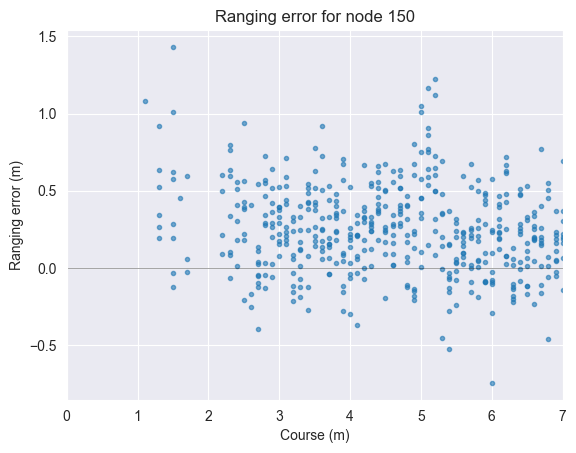

In [ ]:
plt.plot(
    dataset_complete[dataset_complete.target == 150].course_dist,
    dataset_complete[dataset_complete.target == 150].ranging_error,
    '.', alpha=0.6
)
plt.title('Ranging error for node 150')
plt.xlabel('Course (m)')
plt.ylabel('Ranging error (m)')
plt.xlim(0, 7)
plt.axhline(0, color='k', alpha=0.5, linewidth=0.5)

Plotting example (RSSI for node 150):

(0.0, 7.0)

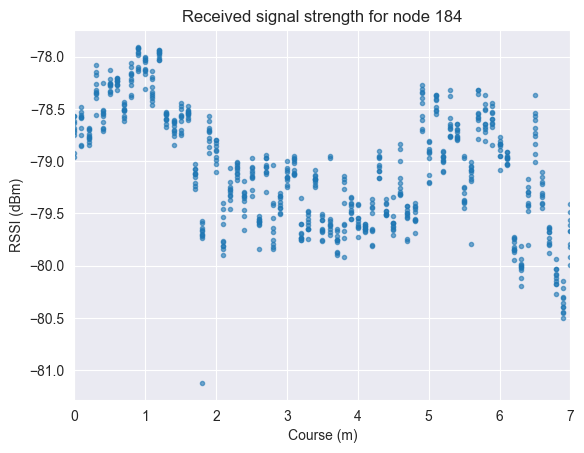

In [ ]:
plt.plot(
    dataset_complete[dataset_complete.target == 184].course_dist,
    dataset_complete[dataset_complete.target == 184].rssi_mean,
    '.', alpha=0.6
)
plt.title('Received signal strength for node 184')
plt.xlabel('Course (m)')
plt.ylabel('RSSI (dBm)')
plt.xlim(0,7)

Plotting example (distance for node 150):

(0.0, 7.0)

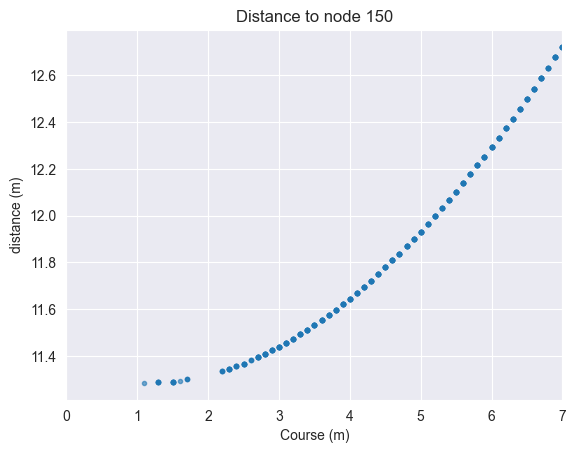

In [ ]:
plt.plot(
    dataset_complete[dataset_complete.target == 150].course_dist,
    dataset_complete[dataset_complete.target == 150].distance,
    '.', alpha=0.6
)
plt.title('Distance to node 150')
plt.xlabel('Course (m)')
plt.ylabel('distance (m)')
plt.xlim(0,7)

## Dataset 2 creation

We now proceed to decode the information found in `register_dump_CIR` to create the second dataset:

In [ ]:
prev_target = dataset_complete.iloc[0].target
row_list = []
for idx, row in dataset_complete.iterrows():
    # Show progress
    print(f'At row {idx}     ', end='\r')
    # Check if a new target is being processed
    if row.target != prev_target:
        # Save the data
        CIR = pd.DataFrame(row_list)
        # Dump register_dump_CIR into a json
        CIR.register_dump_CIR = CIR.register_dump_CIR.apply(lambda x : json.dumps(x))
        CIR.to_csv(f'{EXPORT_LOC}/Dataset_2/CIR_{row.initiator}_{prev_target}.csv', index=False)
        # Reset the row list
        row_list = []
    # Decode CIR
    CIR_dump = row.register_dump_CIR
    first_index = CIR_dump['ACC_MEM_first_index']
    decoded_bytes = base64.b64decode(CIR_dump['ACC_MEM'])
    row_add = dict(row)
    row_add['CIR_number'] = idx
    # Transform from first_index - first_index + 200 to 0 - 200
    row_add['FP_index'] = int(CIR_dump['FP_INDEX'] / (2 ** 6) - first_index)
    cur_idx = 0
    # ACC_MEM is a base-64 encoded string containg ACC_MEM content : 16 bits complex samples, written in big-endian
    for i in range(0, len(decoded_bytes), 4):
        r = int.from_bytes(decoded_bytes[i:i+2], "big", signed=True)
        i = int.from_bytes(decoded_bytes[i+2:i+4], "big", signed=True)
        row_add[f'modulus_comp_{str(cur_idx).zfill(3)}'] = (r + 1j * i)
        row_add[f'modulus_abs_{str(cur_idx).zfill(3)}'] = abs(r + 1j* i)
        cur_idx += 1
    row_list.append(row_add)
    prev_target = row.target
# Save the last DataFrame
CIR = pd.DataFrame(row_list)
CIR.register_dump_CIR = CIR.register_dump_CIR.apply(lambda x : json.dumps(x))
CIR.to_csv(f'{EXPORT_LOC}/Dataset_2/CIR_{row.initiator}_{prev_target}.csv', index=False)

To re-read the data

In [ ]:
df_test = pd.read_csv(f'{EXPORT_LOC}/Dataset_2/CIR_183_150.csv')
# Fetch register_dump_CIR as dict rather than string
df_test.register_dump_CIR = df_test.register_dump_CIR.apply(lambda x : json.loads(x))
# Fetch modulus_comp_XXX as complex rather than string
for i in range(200):
    col_name = f'modulus_comp_{str(i).zfill(3)}'
    df_test[col_name] = df_test[col_name].astype(complex)
# Delete the column register_dump_CIR (if not needed)
# Uncomment if you need the column
df_test.drop(['register_dump_CIR'], axis=1, inplace=True)

## Dataset 2 examples

Plotting example (CIR between 183 and 150 course distance of 1.1m):

Text(0, 0.5, 'Modulus')

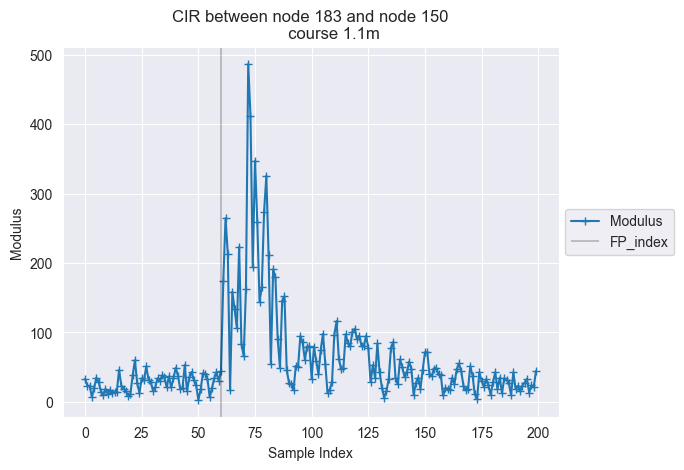

In [ ]:
columns = [f'modulus_abs_{str(i).zfill(3)}' for i in range(200)]
plt.plot(
    np.array(df_test[columns].iloc[0]),
    '+-',
    label='Modulus'
)
plt.axvline(df_test.iloc[0].FP_index, color='k', linewidth=0.3, label='FP_index')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title(f"""CIR between node {df_test.iloc[0].initiator} and node {df_test.iloc[0].target}
          course {np.round(df_test.iloc[0].course_dist, 2)}{df_test.iloc[0].ranging_unit}""")
plt.xlabel('Sample Index')
plt.ylabel('Modulus')